# Best Linear Projections of CATE for Targeting: Promises and Pitfalls

Best Linear Projections of Conditional Average Treatment (CATE-BLP) effects can be a useful way to guide treatment targeting policies. This notebook explores some of their promise and pitfalls. 

## What do we mean by optimal treatment regime?

Imagine for an individual $i$ that we can choose to apply treatment $W = 1$ or $W = 0$. We want to chose the treatment $W_i$ when it will cause a positive incremental incremental return:

$$
W_i = 
\begin{cases}
& 1, & \text{if}\ (Y_i(1) - Y_i(0)) - \kappa_i > 0 \\
& 0, & \text{otherwise}
\end{cases}
$$

where $Y_i(1)$ and $Y_i(0)$ are the outcomes under treatment and no treatment, repectively, and $\kappa_i$ reflects costs for applying the treatment to individual $i$. Typically, $\kappa_i \ge 0$ as we usually don't want to apply a treatment with no or negative incremental value. $\kappa_i > 0$ reflects the existence of a non-zero cost of treatment for unit $i$.

Assume that $\kappa_i$ is known and we estimate $\tau(x) = Y_i(1) - Y_i(0)$ using some experimental or quasi-experimental study where we also observe individual's characteristics $X$. 

## When does BLP-CATE help us and when does BLP-CATE hurt us?

BLP-CATE allows us to make this estimation $(\widehat{\tau_{BLP}} (A_{i}))$ for an individual given some subset of their covariates $A_i$ from the total set of observed covariates $X$ where $A \subseteq X$. How useful this method will be for creating an optimal treatment policy depends on the relationship between $(\widehat{\tau_{BLP}} (A_{i}))$, $\tau(x)$, and $\kappa$ summed across a population eligible for treatment.

Let's assume we can base our treatment regime on either:

1. **Treat All** treating everyone when the Average Treatment Effect is greater than 0 or 

2. **Target Treatment** treating only indiviudals where $\widehat{\tau_{BLP}} (A_{i}) > \kappa_i$.

Under what conditions will each treatment regime basis be preferable?

## Simulation study   

The first plot shows a number of simulated $t$ with a range of "adjustments" that shift the distribution up or down. 

Which treatment strategy--treat all or targeted treatment based on CATE-BLP--is better in each of these scenarios?


In [10]:
remotes::install_github("christophergandrud/blpopt")
remotes::install_github("christophergandrud/drlearner")
xfun::pkg_attach2("dplyr", "blpopt", "drlearner", "tidyr", "ggplot2")

theme_set(theme_minimal())

Skipping install of 'blpopt' from a github remote, the SHA1 (ab7ee186) has not changed since last install.
  Use `force = TRUE` to force installation

Skipping install of 'drlearner' from a github remote, the SHA1 (9f724f1f) has not changed since last install.
  Use `force = TRUE` to force installation



In [11]:
tau_finder <- function(tau_adjustment = 0) {
    x <- seq(-3, 3, by = 0.1)
    1 / (1 + exp(-x)) + tau_adjustment
}

In [12]:
tau_adjustments <- c(-0.3, -0.1, 0, 0.1, 0.3)
df_taus <- data.frame(matrix(nrow = 61, ncol = length(tau_adjustments)))

for (i in seq_along(tau_adjustments)) {
    df_taus[, i] <- tau_finder(tau_adjustments[i])
}
names(df_taus) <- tau_adjustments
df_taus$X <- seq(-3, 3, by = 0.1)
df_taus <- pivot_longer(df_taus, 1:length(tau_adjustments))
df_taus$name <- factor(df_taus$name, levels = tau_adjustments)
head(df_taus)

X,name,value
<dbl>,<fct>,<dbl>
-3.0,-0.3,-0.25257413
-3.0,-0.1,-0.05257413
-3.0,0,0.04742587
-3.0,0.1,0.14742587
-3.0,0.3,0.34742587
-2.9,-0.3,-0.24784644


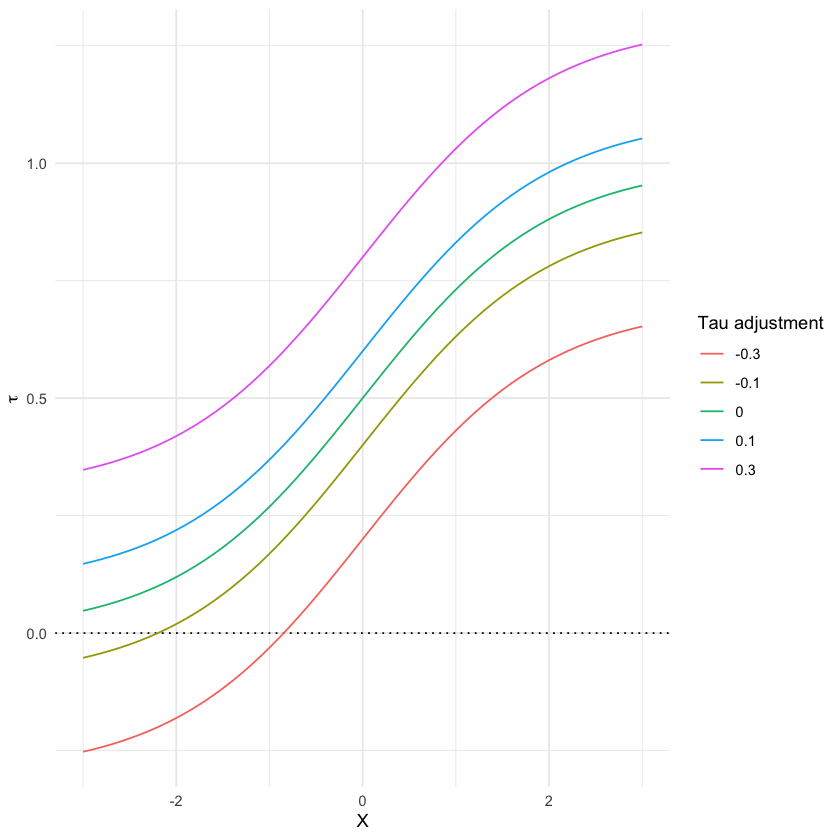

In [13]:
ggplot(df_taus, aes(X, value, color = name)) +
    geom_hline(yintercept = 0, linetype = "dotted") +
    geom_line() + 
    scale_color_discrete(name = "Tau adjustment") +
    ylab(expression(tau))

In [14]:
sim_gain <- function(tau_adjustment = 0) {
    set.seed(3214)
    n <- 2000
    p <- 20
    X <- matrix(rnorm(n * p), n, p)

    # CATE varies along one dim only.
    tau_ex <- function(x) {
    (1 / (1 + exp(-x))) + tau_adjustment
    }
    TAU <- tau_ex(X[, 3])

    # Propensity and Outcome vary along only 2 dimensions
    W <- rbinom(n, 1, 1 / (1 + exp(-X[, 1] - X[, 2])))
    Y <- pmax(X[, 2] + X[, 3], 0) + rowMeans(X[, 4:6]) / 2 + W * TAU + rnorm(n)

    # CATE-BLP with DR Learner (Kennedy 2022)
    drl <- dr_learner(X, Y, W)
    blp_drl <- cate_blp(drl, X[, 3])

    # Bootstrapped total realised profit 
    total_pred_raw <- cate_blp_bootstrap(blp_drl, iterations = 1000, 
                                 output = "raw.list", tau.treatment.baseline = 0)

    total_pred_df <- bind_rows(total_pred_raw, .id = "sample")

    total_pred_df$realised_outcome <- ifelse(total_pred_df$predictions > 0,
                                         tau_ex(total_pred_df$A), 0)   
    total_pred_df$diff_targeted_all <- total_pred_df$realised_outcome - tau_ex(total_pred_df$A)

    predicted_vs_optimal_cate <- total_pred_df %>% group_by(sample) %>%
                                    summarise(diff_targeted_all = sum(diff_targeted_all))
    predicted_vs_optimal_cate$tau_adjustment = tau_adjustment  
    return(predicted_vs_optimal_cate)                           
}

In [15]:
tau_adjustments <- c(-0.3, -0.1, 0, 0.1, 0.3)
df <- data.frame()

for (i in tau_adjustments) {
    df <- rbind(df, sim_gain(i))
}

In [16]:
df_long <- df[,-1] %>% pivot_longer(diff_targeted_all)
df_long$tau_adjustment <- factor(df_long$tau_adjustment)

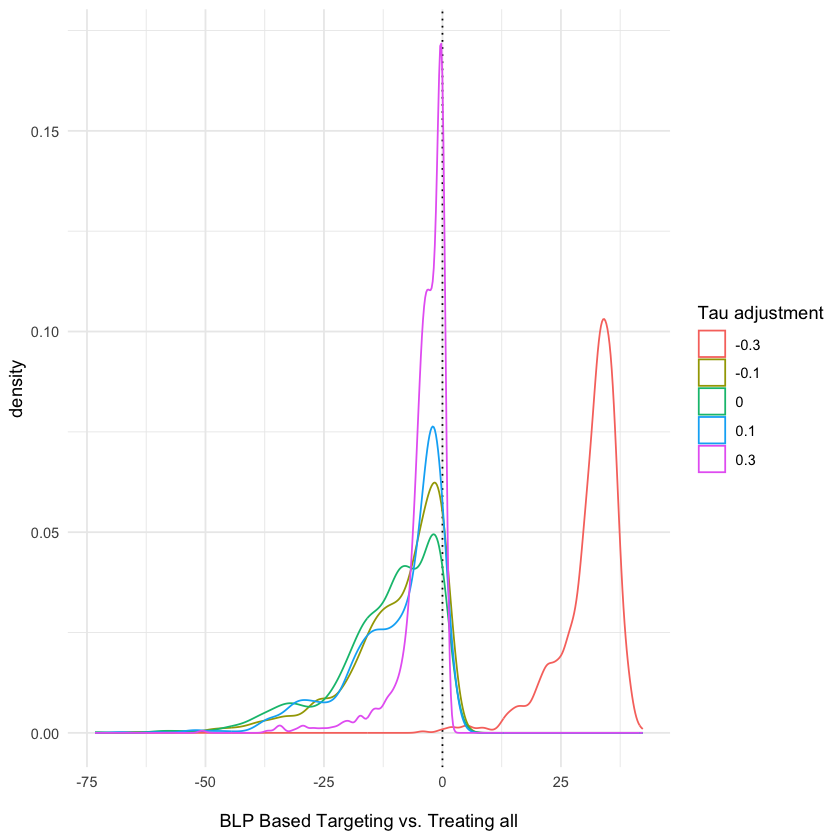

In [17]:
ggplot(df_long, aes(value, color = tau_adjustment)) +
    geom_vline(xintercept = 0, linetype = "dotted") +
    geom_density() +
    scale_color_discrete(name = "Tau adjustment") +
    xlab("\nBLP Based Targeting vs. Treating all")

The previous plot shows that CATE-BLP targeted treaments perform better the more the true $t$ in the treatable population is distributed on both sides of $\kappa$ (0 in this case). 